Analizar el funcionamiento de las siguientes capas del módulo torch.nn , indicando:
1. ¿Cuál es el input esperado? (dimensiones, formato de batch, etc)
- Forma por defecto: (seq_len, batch, input_size).
- Si se usa batch_first=True, la forma cambia a (batch, seq_len, input_size).
Donde:
- seq_len: longitud de la secuencia (ventana temporal).
- batch: número de secuencias en el batch.
- input_size: número de características por timestep (en series univariadas = 1).
2. ¿Cuál es el output que devuelve cada capa?
- output: tensor con todos los estados ocultos para cada timestep.
- Forma: (seq_len, batch, hidden_size * num_directions) o (batch, seq_len, hidden_size * num_directions) si batch_first=True
- h_n: último estado oculto de la secuencia.
- Forma: (num_layers * num_directions, batch, hidden_size).
3. ¿Qué parámetros de configuración existen (hidden size, número de capas, bidireccionalidad)
- input_size: número de características de entrada.
- hidden_size: número de unidades en el estado oculto.
- num_layers: número de capas recurrentes apiladas.
- bias: incluye/bias en las transformaciones internas (por defecto True).
- batch_first: organiza la entrada como (batch, seq_len, input_size) si es True.
- dropout: probabilidad de dropout entre capas (solo si num_layers > 1).
- bidirectional: si es True, la RNN será bidireccional (procesa secuencias adelante y atrás).
Investiga el dataset Sunspots:
1. ¿Qué mide?
- El dataset Sunspots mide el número mensual de manchas solares observadas en la superficie del Sol.
2. ¿Cuál es el rango temporal de los datos?
- El registro comienza en enero de 1749 y continúa hasta la actualidad (la versión más común en Kaggle llega hasta ~2017, la versión de TensorFlow datasets llega hasta ~2022).
3. ¿Por qué es útil para predecir series temporales?
- Presenta ciclos naturales (~11 años), lo que lo convierte en un ejemplo clásico de serie temporal periódica.
- Sirve para entrenar modelos de predicción porque combina patrones cíclicos con variaciones a corto plazo.

In [1]:
import os
import math
import time
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
df = pd.read_csv(url, header=0, parse_dates=['Month'])
df.columns = ['Month', 'Sunspots']
df.head()


,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0


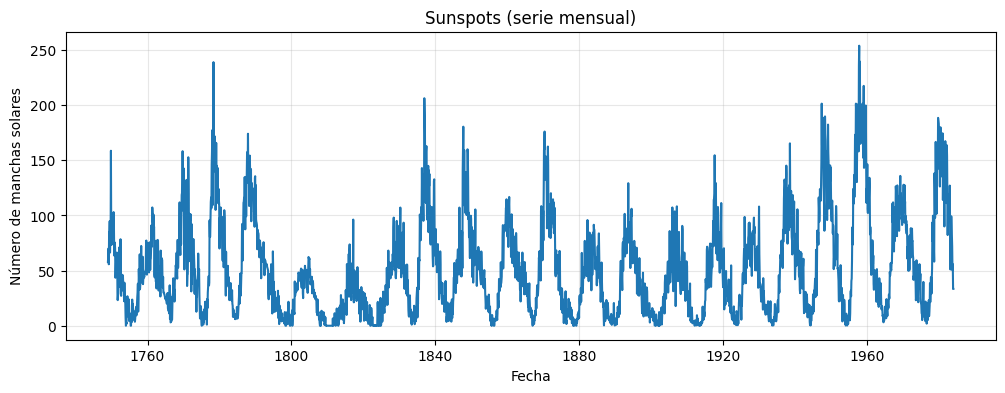

In [ ]:
# Visualización de la serie completa
plt.figure(figsize=(12,4))
plt.plot(df['Month'], df['Sunspots'])
plt.title("Sunspots (serie mensual)")
plt.xlabel("Fecha")
plt.ylabel("Número de manchas solares")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Normalización y creación de ventanas
series = df['Sunspots'].values.reshape(-1,1) 

scaler = MinMaxScaler(feature_range=(0,1))
series_scaled = scaler.fit_transform(series).flatten() 

# Pares (X_window, y_next)
def create_windows(data, window_size, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - (horizon-1)):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size + (horizon-1)])
    return np.array(X), np.array(y)

def temporal_splits(data, train_ratio=0.7, val_ratio=0.15):
    n = len(data)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = data[:n_train]
    val = data[n_train:n_train+n_val]
    test = data[n_train+n_val:]
    return train, val, test

train_raw, val_raw, test_raw = temporal_splits(series_scaled, train_ratio=0.7, val_ratio=0.15)
print("Tamaños -> train:", len(train_raw), "val:", len(val_raw), "test:", len(test_raw))


Tamaños -> train: 1973 val: 423 test: 424


In [ ]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, data_array, window_size):
        X, y = create_windows(data_array, window_size)
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
#Modelo RNN 
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=batch_first,
                          bidirectional=bidirectional)
        directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * directions, 1)

    def forward(self, x):
        out, h_n = self.rnn(x)  
        last = out[:, -1, :]    
        out = self.fc(last)    
        return out


In [ ]:
#Entrenamiento y evaluación
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, weight_decay=0.0):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_losses.append(loss.item())

        avg_train = np.mean(train_losses)
        avg_val = np.mean(val_losses)
        history["train_loss"].append(avg_train)
        history["val_loss"].append(avg_val)

        if epoch % 10 == 0 or epoch==1:
            print(f"Epoch {epoch}/{epochs} — train_loss: {avg_train:.6f} — val_loss: {avg_val:.6f}")

    return history


In [ ]:
#Evaluar en test y desnormalizar predicciones
def evaluate_model(model, test_dataset):
    model.to(device)
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    preds, truths = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            p = model(xb).cpu().numpy().flatten()
            preds.extend(p.tolist())
            truths.extend(yb.numpy().flatten().tolist())
    preds = np.array(preds)
    truths = np.array(truths)
    preds_inv = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
    truths_inv = scaler.inverse_transform(truths.reshape(-1,1)).flatten()
    mse = mean_squared_error(truths_inv, preds_inv)
    mae = mean_absolute_error(truths_inv, preds_inv)
    return mse, mae, preds_inv, truths_inv


In [ ]:
window_sizes = [5, 10, 20, 100]   
results = []

for w in window_sizes:
    print("\n" + "="*60)
    print(f"Entrenando RNN con window_size = {w}")
    train_ds = TimeSeriesWindowDataset(train_raw, window_size=w)
    val_ds = TimeSeriesWindowDataset(val_raw, window_size=w)
    test_ds = TimeSeriesWindowDataset(test_raw, window_size=w)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

    model = SimpleRNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False)

    start_time = time.time()
    history = train_model(model, train_loader, val_loader, epochs=60, lr=1e-3)
    elapsed = time.time() - start_time
    print(f"Tiempo de entrenamiento: {elapsed:.1f}s")

    # evaluar en test
    mse, mae, preds_inv, truths_inv = evaluate_model(model, test_ds)
    print(f"Test MSE (desescalado): {mse:.4f}, MAE: {mae:.4f}")

    results.append({
        "window": w,
        "history": history,
        "train_time_s": elapsed,
        "test_mse": mse,
        "test_mae": mae,
        "preds": preds_inv,
        "truths": truths_inv
    })



Entrenando RNN con window_size = 5
Epoch 1/60 — train_loss: 0.023364 — val_loss: 0.023550
Epoch 10/60 — train_loss: 0.003922 — val_loss: 0.005555
Epoch 20/60 — train_loss: 0.003800 — val_loss: 0.004880
Epoch 30/60 — train_loss: 0.003588 — val_loss: 0.004703
Epoch 40/60 — train_loss: 0.003565 — val_loss: 0.004993
Epoch 50/60 — train_loss: 0.003588 — val_loss: 0.004848
Epoch 60/60 — train_loss: 0.003521 — val_loss: 0.004639
Tiempo de entrenamiento: 11.6s
Test MSE (desescalado): 334.1716, MAE: 13.5744

Entrenando RNN con window_size = 10
Epoch 1/60 — train_loss: 0.020693 — val_loss: 0.026303
Epoch 10/60 — train_loss: 0.003774 — val_loss: 0.005440
Epoch 20/60 — train_loss: 0.003697 — val_loss: 0.005037
Epoch 30/60 — train_loss: 0.003556 — val_loss: 0.004931
Epoch 40/60 — train_loss: 0.003547 — val_loss: 0.004866
Epoch 50/60 — train_loss: 0.003530 — val_loss: 0.004784
Epoch 60/60 — train_loss: 0.003536 — val_loss: 0.004864
Tiempo de entrenamiento: 7.8s
Test MSE (desescalado): 337.7697, MAE

In [ ]:
summary = pd.DataFrame([{
    "window": r["window"],
    "train_time_s": round(r["train_time_s"],2),
    "test_mse": r["test_mse"],
    "test_mae": r["test_mae"]
} for r in results]).sort_values("window").reset_index(drop=True)

display(summary)


,window,train_time_s,test_mse,test_mae
0,5,11.61,334.171592,13.574373
1,10,7.82,337.769734,13.520954
2,20,11.15,342.514944,13.535533
3,100,29.75,362.047099,13.899257


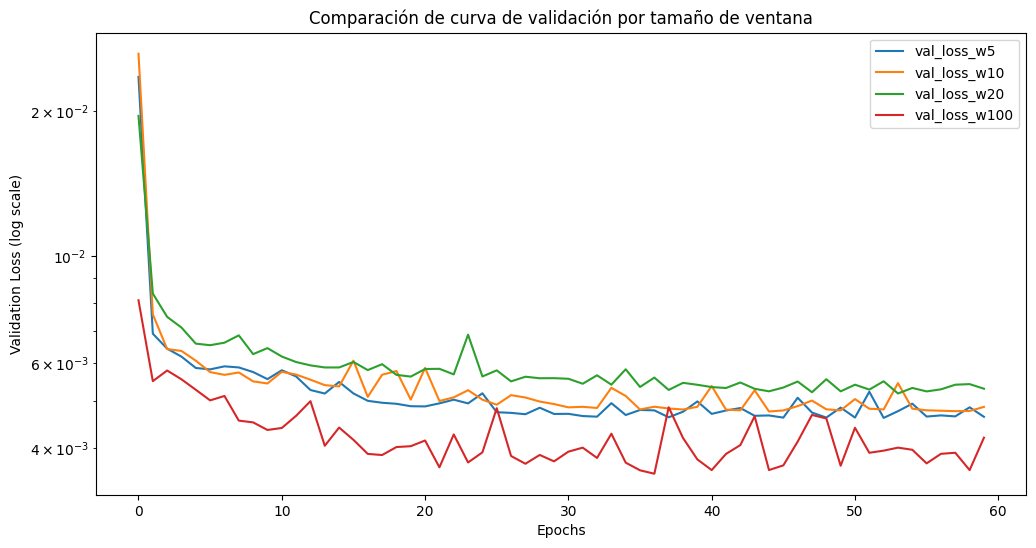

In [ ]:
plt.figure(figsize=(12,6))
for r in results:
    h = r["history"]
    plt.plot(h["val_loss"], label=f"val_loss_w{r['window']}")
plt.yscale("log")  
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (log scale)")
plt.title("Comparación de curva de validación por tamaño de ventana")
plt.legend()
plt.show()


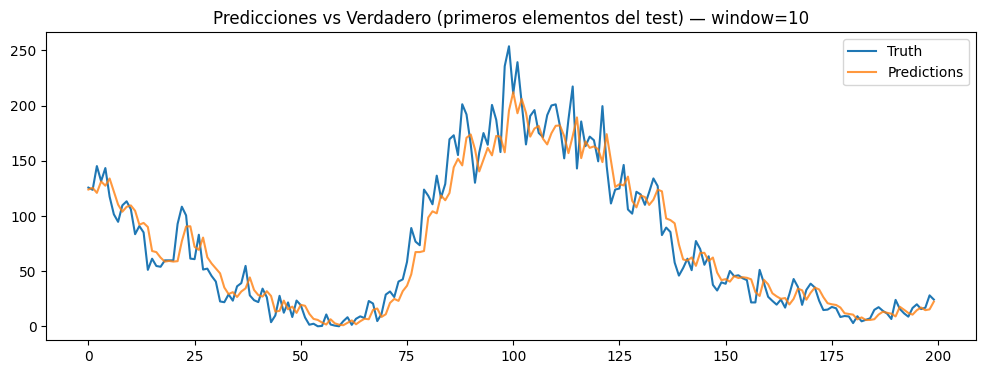

In [ ]:
exp = next(r for r in results if r["window"]==10)
preds = exp["preds"]
truths = exp["truths"]
n_plot = min(200, len(preds))

plt.figure(figsize=(12,4))
plt.plot(truths[:n_plot], label="Truth")
plt.plot(preds[:n_plot], label="Predictions", alpha=0.8)
plt.title("Predicciones vs Verdadero (primeros elementos del test) — window=10")
plt.legend()
plt.show()


In [ ]:
output_dir = Path("rnn_results")
output_dir.mkdir(exist_ok=True)
summary.to_csv(output_dir/"summary_results.csv", index=False)
print(f"Resumen guardado en {output_dir/'summary_results.csv'}")


Resumen guardado en rnn_results\summary_results.csv
